# fusion_analysis_d23a
BSG, 2022 - 2023

In [1]:
from functools import cache
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import warnings
import xarray as xr

In [2]:
%load_ext watermark
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.12.0

seaborn   : 0.12.2
xarray    : 2023.4.1
matplotlib: 3.7.1
numpy     : 1.24.2
pandas    : 2.0.0



In [3]:
# Matplotlib settings
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titleweight'] = 'bold'  # titles for subplots
plt.rcParams['figure.titleweight'] = 'bold'  # suptitle
plt.rcParams['figure.titlesize'] = 'x-large'  # suptitle

## Functions

### Read quantile function corresponding to sea-level projection
The AR6 data have been loaded from https://doi.org/10.5281/zenodo.6382554.

In [4]:
@cache
def read_sea_level_qf(projection_source='fusion', component='total', scenario='SSP5-8.5', year=2100):
    """
    read_sea_level_qf(projection_source, component, scenario, year)

    Read quantile function corresponding to sea-level projection (either AR6 ISMIP6, AR6 SEJ, p-box, or fusion).

    Parameters
    ----------
    projection_source : str
        Projection source. Options are 'ISMIP6'/'model-based' (emulated ISMIP6),
        'SEJ'/'expert-based' (Bamber et al. structured expert judgment),
        'p-box'/'bounding quantile function' (p-box bounding quantile function of ISMIP6 & SEJ),
        and 'fusion' (fusion of ISMIP6 and bounding quantile function, weighted using triangular function; default).
    component : str
        Component of global sea level change. Options are 'GrIS' (Greenland Ice Sheet), 'EAIS' (East Antarctic Ice Sheet),
        'WAIS' (West Antarctic Ice Sheet), and 'total' (total global-mean sea level; default).
        Note: for ISMIP6, 'PEN' is also included in 'WAIS'.
    scenario : str
        Scenario. Options are 'SSP1-2.6' and 'SSP5-8.5' (default).
    year : int
        Year. Default is 2100.

    Returns
    -------
    qf_da : xarray DataArray
        DataArray of sea level change in metres for different quantiles.
    """
    # Case 1: p-box or fusion
    if projection_source in ['p-box', 'bounding quantile function', 'fusion']:
        # If p-box bounding quantile function...
        if projection_source in ['p-box', 'bounding quantile function']:
            # Call function recursively to get ISMIP6 and SEJ data
            ism_da = read_sea_level_qf(projection_source='ISMIP6', component=component, scenario=scenario, year=year)
            sej_da = read_sea_level_qf(projection_source='SEJ', component=component, scenario=scenario, year=year)
            # Initialize qf_da as copy of ism_da
            qf_da = ism_da.copy()
            # Loop over quantile probabilities
            for q, quantile in enumerate(qf_da.quantiles):
                # Get data for this quantile probability
                ism = ism_da[q].data
                sej = sej_da[q].data
                if quantile == 0.5:  # if median, use mean of ISMIP6 and SEJ
                    qf_da[q] = (ism + sej) / 2
                elif quantile < 0.5:  # if quantile < 0.5, use min
                    qf_da[q] = np.minimum(ism, sej)
                else:  # if > 0.5, use maximum
                    qf_da[q] = np.maximum(ism, sej)
        # If fusion...
        elif projection_source == 'fusion':
            # Call function recursively to get ISMIP6 and p-box bounding quantile function data
            ism_da = read_sea_level_qf(projection_source='ISMIP6', component=component, scenario=scenario, year=year)
            pbox_da = read_sea_level_qf(projection_source='p-box', component=component, scenario=scenario, year=year)
            # Weights for ISMIP6 emulator data: triangular function, with peak at median
            weights_q = 1 - np.abs(ism_da.quantiles - 0.5) * 2  # _q indicates quantile probability dimension
            # Combine ISMIP6 and p-box bounding quantile function data using weights; rely on automatic broadcasting/alignment
            qf_da = weights_q * ism_da + (1 - weights_q) * pbox_da
            # Copy units attribute
            qf_da.attrs['units'] = ism_da.attrs['units']
        # Is result monotonic?
        if np.any((qf_da[1:].data - qf_da[:-1].data) < 0):  # allow difference to equal zero
            warnings.warn(f'read_sea_level_qf{projection_source, component, scenario, year} result is not monotonic wrt quantiles.')
        # Return result (Case 1)
        return qf_da

    # Case 2: ISMIP6 or SEJ
    # Check projection_source argument and identify corresponding projection_code and workflow_code
    elif projection_source in ['ISMIP6', 'model-based']:  # emulated ISMIP6
        projection_code = 'ismipemu'  # projection_code for individual ice-sheet components
        workflow_code = 'wf_1e'  # workflow_code for total GMSL
    elif projection_source in ['SEJ', 'expert-based']:  # Bamber et al structured expert judgment
        projection_code = 'bamber'
        workflow_code = 'wf_4'
    else:
        raise ValueError(f'Unrecognized argument value: projection_source={projection_source}')
    # Check component argument
    if component not in ['EAIS', 'WAIS', 'PEN', 'GrIS', 'total']:
        raise ValueError(f'Unrecognized argument value: component={component}')
    # Check scenario argument and identify corresponding scenario_code
    if scenario in ['SSP1-2.6', 'SSP5-8.5']:
        scenario_code = scenario.replace('-', '').replace('.', '').lower()
    else:
        raise ValueError(f'Unrecognized argument value: scenario={scenario}')
    # Input directory and file
    if component == 'total':
        in_dir = Path(f'data/ar6/global/dist_workflows/{workflow_code}/{scenario_code}').expanduser()
        in_fn = in_dir / 'total-workflow.nc'
    else:
        in_dir = Path(f'data/ar6/global/dist_components').expanduser()
        if component == 'GrIS':
            in_fn = in_dir / f'icesheets-ipccar6-{projection_code}icesheet-{scenario_code}_GIS_globalsl.nc'
        else:
            in_fn = in_dir / f'icesheets-ipccar6-{projection_code}icesheet-{scenario_code}_{component}_globalsl.nc'
    # Does input file exist?
    if not in_fn.exists():
        raise FileNotFoundError(in_fn)
    # Read data
    qf_da = xr.open_dataset(in_fn)['sea_level_change'].squeeze().drop_vars('locations').sel(years=year)
    # Convert units from mm to m
    if qf_da.attrs['units'] == 'mm':
        qf_da *= 1e-3
        qf_da.attrs['units'] = 'm'
    # If ISMIP6 WAIS, also include PEN (assuming perfect dependence)
    if projection_code == 'ismipemu' and component == 'WAIS':
        qf_da += read_sea_level_qf(projection_source='ISMIP6', component='PEN', scenario=scenario, year=year)
        print(f'read_sea_level_qf{projection_source, component, scenario, year}: including PEN in WAIS.')
    # Is result monotonic?
    if np.any((qf_da[1:].data - qf_da[:-1].data) < 0):
        warnings.warn(f'read_sea_level_qf{projection_source, component, scenario, year} result is not monotonic wrt quantiles.')
    # Return result (Case 2)
    return qf_da

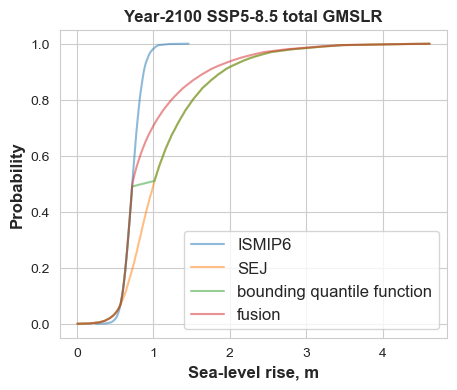

CPU times: user 1.47 s, sys: 171 ms, total: 1.64 s
Wall time: 1.2 s


In [5]:
%%time
# Example: plot quantile function of year-2100 SSP5-8.5 total GMSLR for different projection sources
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for projection_source in ['ISMIP6', 'SEJ', 'bounding quantile function', 'fusion']:
    in_da = read_sea_level_qf(projection_source=projection_source, component='total', scenario='SSP5-8.5', year=2100)
    in_da.plot(y='quantiles', ax=ax, alpha=0.5, label=projection_source)
# Customise plot
ax.set_title('Year-2100 SSP5-8.5 total GMSLR')
ax.set_xlabel(f'Sea-level rise, {in_da.units}')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

### Sample sea-level marginal distribution

In [6]:
@cache
def sample_sea_level_marginal(projection_source='fusion', component='total', scenario='SSP5-8.5', year=2100,
                              n_samples=int(1e6), plot=False):
    """
    sample_sea_level_marginal(projection_source, component, scenario, year, n_samples, plot)

    Sample marginal distribution corresponding to sea-level projection (either AR6 ISMIP6, AR6 SEJ, p-box, or fusion).

    Parameters
    ----------
    projection_source : str
        Projection source. Options are 'ISMIP6'/'model-based' (emulated ISMIP6),
        'SEJ'/'expert-based' (Bamber et al. structured expert judgment),
        'p-box'/'bounding quantile function' (p-box bounding quantile function of ISMIP6 & SEJ),
        and 'fusion' (fusion of ISMIP6 and bounding quantile function, weighted using triangular function; default).
    component : str
        Component of global sea level change. Options are 'GrIS' (Greenland Ice Sheet), 'EAIS' (East Antarctic Ice Sheet),
        'WAIS' (West Antarctic Ice Sheet), and 'total' (total global-mean sea level; default).
        Note: for ISMIP6, 'PEN' is also included in 'WAIS'.
    scenario : str
        Scenario. Options are 'SSP1-2.6' and 'SSP5-8.5' (default).
    year : int
        Year. Default is 2100.
    n_samples : int
        Number of samples. Default is int(1e6).
    plot : bool
        If True, plot diagnostic ECDF and histogram. Default is False.

    Returns
    -------
    marginal_n : numpy array
        A one-dimensional array of randomly drawn samples.
    """
    # Read quantile function data
    qf_da = read_sea_level_qf(projection_source=projection_source, component=component, scenario=scenario, year=year)
    # Sample uniform distribution
    rng = np.random.default_rng(12345)
    uniform_n = rng.uniform(size=n_samples)
    # Transform these samples to marginal distribution samples by interpolation of quantile function
    marginal_n = qf_da.interp(quantiles=uniform_n).data
    # Plot diagnostic plots?
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
        sns.ecdfplot(marginal_n, label='marginal_n ECDF', ax=axs[0])
        axs[0].plot(qf_da, qf_da['quantiles'], label='"True" quantile function', linestyle='--')
        sns.histplot(marginal_n, bins=100, label='marginal_n', ax=axs[1])
        for ax in axs:
            ax.legend()
            try:
                ax.set_xlabel(f'{component}, {qf_da.attrs["units"]}')
            except KeyError:
                ax.set_xlabel(component)
        plt.suptitle(f'{projection_source}, {component}, {scenario}, {year}, {n_samples}')
        plt.show()
    return marginal_n

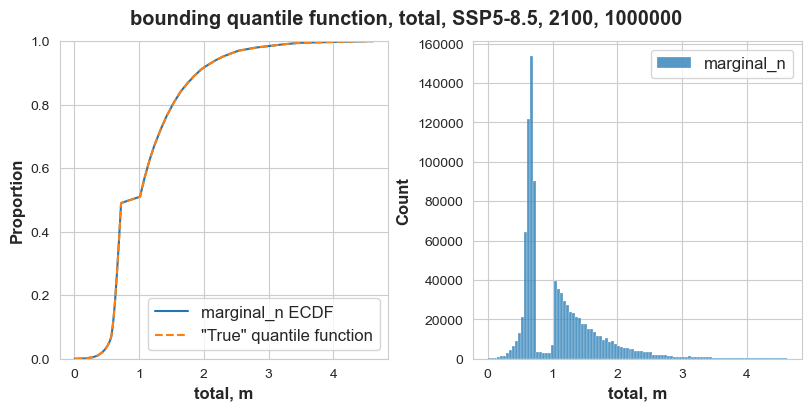

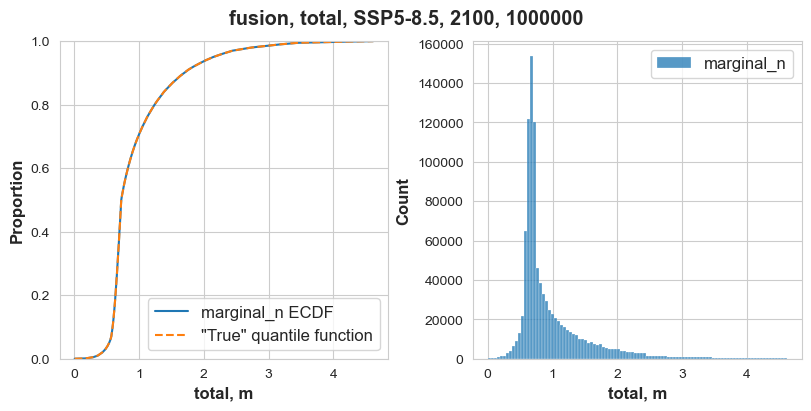

CPU times: user 14 s, sys: 993 ms, total: 15 s
Wall time: 9.8 s


In [7]:
%%time
# Examples
_ = sample_sea_level_marginal(projection_source='bounding quantile function', component='total', scenario='SSP5-8.5', year=2100,
                              n_samples=int(1e6), plot=True)
_ = sample_sea_level_marginal(projection_source='fusion', component='total', scenario='SSP5-8.5', year=2100,
                              n_samples=int(1e6), plot=True)

## Figures

In [8]:
# Location in which to write figures
fig_dir = Path('figs_d23a/')
fig_dir.mkdir(exist_ok=True)

In [9]:
# Counters for figures
f_num = itertools.count(1)  # main figures
s_num = itertools.count(1)  # supplementary figures
o_num = itertools.count(1)  # other figures (including modified figs for presentations)

In [10]:
# Function to name & save a figure (based on https://github.com/grandey/d22a-mcdc)
def name_save_fig(fig,
                  fso='f',  # figure type, either 'f' (main), 's' (supplement), or 'o' (other)
                  exts=('pdf', 'png'),  # extension(s) to use
                  close=False):
    """Name & save a figure, then increase counter."""
    # Name based on counter, then update counter (in preparation for next figure)
    if fso == 'f':
        fig_name = f'fig{next(f_num):02}'
    elif fso == 's':
        fig_name = f's{next(s_num):02}'
    else:
        fig_name = f'o{next(o_num):02}'
    # File location based on extension(s)
    for ext in exts:
        # Sub-directory
        sub_dir = fig_dir.joinpath(f'{fso}_{ext}')
        sub_dir.mkdir(exist_ok=True)
        # Save
        fig_path = sub_dir.joinpath(f'{fig_name}.{ext}')
        fig.savefig(fig_path, bbox_inches='tight')
        # Print file name and size
        fig_size = fig_path.stat().st_size / 1024 / 1024  # bytes -> MB
        print(f'Written {fig_name}.{ext} ({fig_size:.2f} MB)')
    # Suppress output in notebook?
    if close:
        plt.close()
    return fig_name

In [11]:
# Component, scenario, and year to use when plotting figures
component = 'total'
component_name = 'total GMSLR'
scenario = 'SSP5-8.5'
year = 2100
# Colors (for sources)
color_dict = {'model-based': 'green', 'expert-based': 'orange', 'p-box': 'darkred', 'bounding quantile function': 'darkred', 'fusion': 'darkblue'}
# Linestyles (for percentiles)
linestyle_dict = {'99.5th': (0, (1, 4)), '95th': 'dotted', '83rd': 'dashed', '50th': 'dashdot'}

### Quantile functions and weights
Quantile functions of (a) ISMIP6 & SEJ, (b) p-box, (c) fusion.  (d) Weights.

model-based median [5th to 95th]: 0.7 [0.6 to 0.9]
expert-based median [5th to 95th]: 1.0 [0.5 to 2.3]
bounding quantile function median [5th to 95th]: 0.9 [0.5 to 2.3]
fusion median [5th to 95th]: 0.7 [0.5 to 2.1]
Written fig01.pdf (0.03 MB)
Written fig01.png (0.33 MB)


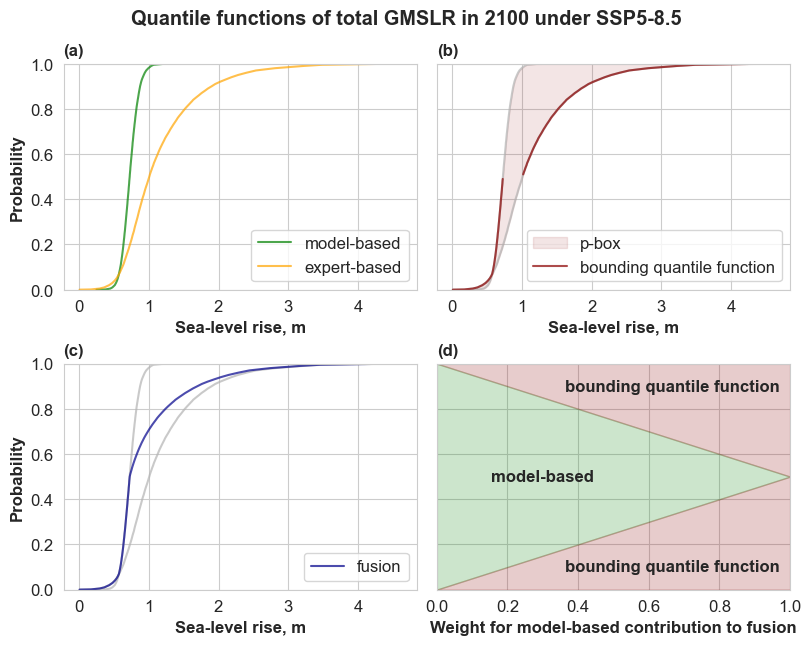

In [12]:
# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, constrained_layout=True)
# (b): shade p-box
ax = axs[0, 1]
ism_da = read_sea_level_qf(projection_source='ISMIP6', component=component, scenario=scenario, year=year)
sej_da = read_sea_level_qf(projection_source='SEJ', component=component, scenario=scenario, year=year)
ax.fill_betweenx(ism_da.quantiles, ism_da, sej_da, color=color_dict['p-box'], alpha=0.1, label='p-box')
# (a), (b), and (c): show quantile functions
for i, sources in enumerate((['model-based', 'expert-based'],
                             ['model-based_g', 'expert-based_g', 'bounding quantile function'],  # '_g' means plot in grey
                             ['model-based_g', 'expert-based_g', 'fusion'])):
    # Subplot axes
    ax = axs.flatten()[i]
    # Loop over projection sources
    for source in sources:
        # Should source be plotted in grey with no label?
        if source[-2:] == '_g':
            color = '0.7'
            label = None
            source = source[:-2]  # remove '_g'
        else:
            color = color_dict[source]
            label = source
        # Get data for required year
        in_da = read_sea_level_qf(projection_source=source, component=component, scenario=scenario, year=year)
        # Plot quantile function
        if source == 'bounding quantile function':  # show discontinuity
            for temp_da, temp_label in ([in_da.where(in_da.quantiles<0.5), label],
                                        [in_da.where(in_da.quantiles>0.5), None]):
                ax.plot(temp_da, temp_da.quantiles, color=color, alpha=0.7, label=temp_label)
        else:
            ax.plot(in_da, in_da.quantiles, color=color, alpha=0.7, label=label)
        # Print median and 5th-95th percentile range (if source plotted in colour with label)
        if label:
            print(f'{source} median [5th to 95th]: {in_da.sel(quantiles=0.5).data:0.1f} '
                  f'[{in_da.sel(quantiles=0.05).data:0.1f} to {in_da.sel(quantiles=0.95).data:0.1f}]')
    # Customise subplot
    ax.legend(loc='lower right')
    ax.set_ylim([0, 1])
    ax.set_title(f'({chr(97+i)})', loc='left')
    ax.set_xlabel(f'Sea-level rise, {in_da.units}')
    if i in [0, 2]:
        ax.set_ylabel('Probability')
# (d): show weights
ax = axs[1, 1]
quantiles_q = in_da.quantiles  # get quantiles from most recently opened in_da (see above)
weights_q = 1 - np.abs(quantiles_q - 0.5) * 2  # _q indicates quantiles dimension
ax.fill_betweenx(quantiles_q, 0, weights_q, color=color_dict['model-based'], alpha=0.2)  # shade ISMIP6 weights
ax.fill_betweenx(quantiles_q, 1, weights_q, color=color_dict['bounding quantile function'], alpha=0.2)  # shade p-box weights
# Annotate, label x-axis etc
ax.text(0.3, 0.5, 'model-based', fontsize='large', horizontalalignment='center', verticalalignment='center', fontweight='bold')
for y in [0.9, 0.1]:
    ax.text(0.97, y, 'bounding quantile function', fontsize='large', horizontalalignment='right', verticalalignment='center', fontweight='bold')
ax.set_xlim([0, 1])
ax.set_xlabel(f'Weight for model-based contribution to fusion')
ax.set_title(f'({chr(97+3)})', loc='left')
# Further customisation of figure
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize='large')
fig.suptitle(f'Quantile functions of {component_name} in {year} under {scenario}', y=1.05)
# Save figure
name_save_fig(fig, fso='f')
# Show figure
plt.show()

### Violin plots
Violin plots of sampled ISMIP6, fusion, and SEJ. Show percentiles.

Written fig02.pdf (0.03 MB)
Written fig02.png (0.15 MB)


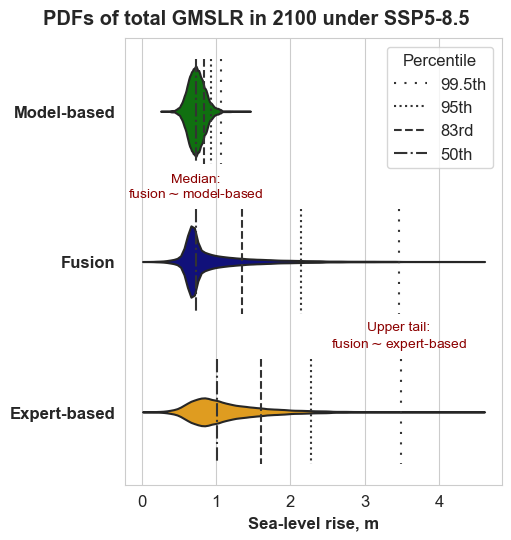

In [13]:
# DataFrame to hold data for different sources
samples_df = pd.DataFrame()
# Loop over sources, sample marginal, and save to DataFrame
for source in ['model-based', 'fusion', 'expert-based']:
    samples_n = sample_sea_level_marginal(projection_source=source, component=component, scenario=scenario, year=year,
                                           n_samples=int(1e6), plot=False)
    samples_df[source] = samples_n
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
# Violin plots
sns.violinplot(data=samples_df, cut=0, palette=color_dict, orient='h', width=0.6, inner=None, ax=ax)
# Percentiles for each source
for i, source in enumerate(['model-based', 'fusion', 'expert-based']):
    for perc_str, linestyle in linestyle_dict.items():
        perc = float(perc_str[:-2])
        val = read_sea_level_qf(projection_source=source, component=component, scenario=scenario, year=year
                                ).sel(quantiles=perc/100).data  # percentiles based on quantile function
        if i == 0:  # label each percentile only once in legend
            label = perc_str
        else:
            label = None
        ax.plot([val, val], [i-0.35, i+0.35], color='0.2', linestyle=linestyle, label=label)
# Annotations
for perc, y, text in zip([50, 99.5], [0.5, 1.5],
                         ['Median:\nfusion$\sim$model-based',
                          'Upper tail:\nfusion$\sim$expert-based']):
    val = read_sea_level_qf(projection_source='fusion', component=component, scenario=scenario, year=year
                           ).sel(quantiles=perc/100).data
    ax.annotate(text, [val, y], ha='center', va='center', color='darkred')
# Customise figure
ax.legend(loc='upper right', title='Percentile', title_fontsize='large')
ax.set_xlabel(f'Sea-level rise, {in_da.units}')
ax.set_yticklabels([s.capitalize() for s in ['model-based', 'fusion', 'expert-based']])
ax.tick_params(axis='both', labelsize='large')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
fig.suptitle(f'PDFs of {component_name} in 2100 under {scenario}', y=1.05)
# Save figure
name_save_fig(fig, fso='f')
# Show figure
plt.show()

In [14]:
! date

Fri May  5 10:28:23 +08 2023
